In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
from sklearn import preprocessing

import pyLDAvis
from pprint import pprint

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import confusion_matrix, precision_score, precision_recall_curve, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation

#from imblearn.over_sampling import SMOTE 
from os import path
from wordcloud import WordCloud, STOPWORDS 
from PIL import Image
from wordcloud import ImageColorGenerator
import re
import pickle
import joblib
import spacy

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from nltk import word_tokenize,sent_tokenize
from nltk.stem.porter import PorterStemmer
import datetime
import warnings

C:\Users\Tanisha Batra\anaconda3\lib\site-packages\nltk\decorators.py:69: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  signature = inspect.formatargspec(regargs, varargs, varkwargs, defaults,


In [2]:
raw_df= pd.read_csv(r'G:/Symbi/Dataset/TelecomPOC New.csv',encoding='utf-8', parse_dates=[1])
raw_df.head()
neg = raw_df[raw_df.Sentiment1=='Negative']

neg = neg.reset_index(drop=True)
text = neg.Tweet.dropna()
print(text)

#raw_df= raw_df[pd.notnull(raw_df['Tweet'])] #Delete rows where Tweet is null.

C:\Users\Tanisha Batra\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0       @Vodafone won't not let me port to @JioCare f...
1            @jiocare Jio internet services depressing. 
2      @jiocare #jiofraud, no action in my complaint,...
3      @jiocare Was recharging for Jio 999 plan. When...
4      @jiocare It's been officially 10 days. Yet, no...
                             ...                        
317         Wants to access News channels through phone.
318    Customer wants to block calls from a particula...
319                                Checking IMEI status.
320    Called to report demise of her grandmother & w...
321                                Checking IMEI status.
Name: Tweet, Length: 322, dtype: object


In [3]:
def clean_tweet(RawSentence):
    """
    removing all hashtags , punctuations, stop_words  and links, also stemming words 
    """
        
    txt = RawSentence.lower()
    word_tokens = word_tokenize(txt)    
    #word_tokens = word_tokenize(RawSentence)    
    
    lemma = WordNetLemmatizer()
    nlp = spacy.load('en_core_web_sm') 

    stop_words = set(stopwords.words('english'))
    stop_words.update(["amp", "rt", "cc"]) # adding twitter specific stop words
    #stop_words = stop_words - set(['no', 'not','nil'])  #removing No, not, nil from stop words     
    stop_words.update(["worst","airtelpresence","sunday","monday","tuesday","wednesday","thursday","friday","saturday","parcel",
                       "weekend","apparently","extremely","worse","consolation","shouldnt","wont","arent","folks","hathway",
                     "better", "other","instead","look","yesterday","unacceptable","miss","couldnt","depress","let","good","one",
                     "thank","record","actually","frustrate","correct","ridiculous","expect","different","pathetic","terrible",
                     "bother","follow","fault","impossible","point","cover","person","ask","speak","things","earlier","mean","select","minutes",
                     "horrible","airtel","hear","current","shall","issue","face","empty","please","check","good","give","four",
                     "literally","years","surprise","compensate","helpful","upset","pls","one","two","three",
                     "situation","multiple","jaipur","choose","company","believe","question","anymore","awful","mumbai","month",
                      "koida","completely","finally", "waste","shock","annoy","maybe","strand","mess","finally","proper","consolation",
                      "plan","place","apology","center","plan","twitter","promise","prefer","count","maybe","shock","longer","meet","play","development",
                      "important","break","reason", "wont","days","first","second","third","attempt","officially","absolutely","hello","yet","know","jio",
                      "january","february","march","april","may","june","july","august","september","october","november","december","without","thankyou",
                      "vodafone","get","vodafoneidea","vicustomercare","vowifi","since","voda","reliancejio","jiocare","time","get","number"])
   
    txt = re.sub(r"(@\S+)", "", txt)  # remove @
    txt = re.sub(r'\W', ' ', str(txt)) # remove all special characters including apastrophie 
    txt = txt.translate(str.maketrans(' ', ' ', string.punctuation)) # remove punctuations 
    txt = re.sub(r'\s+[a-zA-Z]\s+', ' ', txt)   # remove all single characters from within the text (it's -> it s then we need to remove s)
    txt = re.sub(r'\^[a-zA-Z]\s+', ' ', txt) # remove all single characters from beginning of the text 
    txt = re.sub(r'\s+', ' ', txt, flags=re.I) # Substituting multiple spaces with single space
    txt = re.sub(r"(http\S+|http)", "", txt) # remove links 
    #txt = re.sub(r'^b\s+', '', txt) # generally used when text is scrapped online. 'b' is prefixed often indicating binary text. This is not reqd for us 
    txt = [re.sub('\s+', ' ', t) for t  in txt]     # Remove new line characters
    txt = ''.join([i for i in txt if not i.isdigit()]).strip() # remove digits ()
    txt = ' '.join([i for i in txt.split(" ") if i not in stop_words])   # split() is native tokenizer in Python
    #txt = ' '.join(lemma.lemmatize(word) for word in txt.split())           # Used lemmatizer later 
    #txt = ' '.join([PorterStemmer().stem(word=word) for word in txt.split(" ") if word not in stop_words ]) # stem & remove stop words
    #soup = BeautifulSoup(txt) #to scrap information from web pages....not needed here
    #txt = soup.get_text
    
    def deEmojify(inputString):
        return inputString.encode('ascii', 'ignore').decode('ascii')
    
    def stem_tokens(tokens, lemmatize):
        lemmatized = []
        for item in tokens:
            lemmatized.append(lemma.lemmatize(item,'v'))
        return lemmatized
    
    txt = deEmojify(txt)
    tokens =[]
    
    excluded_tags = {"ADJ", "ADV", "ADP", "PROPN","CCONJ","AUX","DET","PRON"}
    for token in nlp(txt):
        if token.pos_ not in excluded_tags:
            tokens.append(token.text)
    
    lemm = stem_tokens(tokens, lemma)
    #tokens = nltk.word_tokenize(txt)
    tokens = [ch for ch in lemm if len(ch)>2] #remove words with character length below 3
    #tokens = [ch for ch in tokens if len(ch)<=15] #remove words with character length above 15 
    
    joined_text = ' '.join(tokens)
        
    return joined_text

C:\Users\Tanisha Batra\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:38: DeprecationWarning: invalid escape sequence \s
<>:38: DeprecationWarning: invalid escape sequence \s
<ipython-input-3-e39f16a0f30c>:38: DeprecationWarning: invalid escape sequence \s
  txt = [re.sub('\s+', ' ', t) for t  in txt]     # Remove new line characters


In [4]:
raw_df['clean_tweet'] = raw_df.Tweet.apply(clean_tweet)

C:\Users\Tanisha Batra\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
# vectorize the corpus. the vectorizer object will convert text to vector form on the basis of frequency (count) of each word in text
#Vectorization is a process of converting the text data into a machine-readable form. Each word forms the index. 
#min_df - will ignore words that are present in min_df percent or less no of documents 
#max_df - will take words that are present in max df percent of all the documents

#vectorizer = CountVectorizer(max_df=0.9, min_df=10, ngram_range=(1,2), token_pattern='\w+|\$[\d\.]+|\S+') 
#tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=20, ngram_range=(1,2), token_pattern='\w+|\$[\d\.]+|\S+') 
vectorizer = CountVectorizer(max_df=0.9, ngram_range=(1,2)) 
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=10, ngram_range=(1,2))


C:\Users\Tanisha Batra\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
# apply transformation. fit_transform() first fits to data, then transform it or vectorizes it.  
from sklearn.feature_extraction.text import TfidfTransformer 

tf = vectorizer.fit_transform(raw_df['clean_tweet']).toarray()
tfidf_feature_matrix = tfidf_vectorizer.fit_transform(raw_df['clean_tweet']).toarray()

print("FEATURE MATRIX IS ",tf)
tf_shape = tf.shape
print("Feature Matrix shape is :",tf_shape)

tfidf_shape = tfidf_feature_matrix.shape
print("TF-IDF Feature Matrix shape is :",tfidf_shape)
print("TF-IDF Feature matrix not getting printed \n")

# tf_feature_names tells us what word each column in the matric represents
tf_feature_names = vectorizer.get_feature_names()
print("Feature names are : ",tf_feature_names)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
#print("TF-IDF Feature names are : ",tfidf_feature_names)

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(tf)
#this transformation is not needed for NMF 

# print idf values 
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=vectorizer.get_feature_names(),columns=["idf_weights"]) 
 
# sort ascending 
df_idf.sort_values(by=['idf_weights'])

#model1 = LatentDirichletAllocation(n_components=number_of_topics, random_state=0,doc_topic_prior=0.1, topic_word_prior=0.01)
#print(model1)
#model1.fit(tf)
#Learn model for the data X with variational Bayes method.
# print log-likelihood

#log_likelihood1 =model1.score(tf)
#perplexity1= model1.perplexity(tf)
#print("  ")
#print("Log likelihood: ", log_likelihood1)
#print("Perplexity: ", perplexity1)



C:\Users\Tanisha Batra\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


FEATURE MATRIX IS  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Feature Matrix shape is : (361, 2759)
TF-IDF Feature Matrix shape is : (361, 57)
TF-IDF Feature matrix not getting printed 

Feature names are :  ['aata', 'aata nahi', 'access', 'access charge', 'access news', 'access sit', 'access video', 'account', 'account balance', 'account transactions', 'acknowledge', 'acknowledge concern', 'action', 'action application', 'action complaint', 'action take', 'activate', 'activate activate', 'activate fiber', 'activate get', 'activate offer', 'activate roam', 'activate service', 'activate support', 'adarsh', 'adarsh baudh', 'add', 'add bill', 'add business', 'add connection', 'add line', 'add ones', 'address', 'address sri', 'address state', 'address village', 'ads', 'ads stay', 'advance', 'advance amount', 'advance fraud', 'advertise', 'advertise ads', 'advertise message', 'adviced', 'adviced roam', 'afford', 'a

,idf_weights
service,2.484925
network,2.686952
customer,2.780770
call,2.797300
want,2.979621
...,...
help connect,6.198497
help connection,6.198497
help fix,6.198497
heat,6.198497


In [7]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=5, random_state=43,  alpha=0.01, l1_ratio=0.5)
nmf_output = nmf.fit_transform(tfidf_feature_matrix)

nmf_feature_names = tfidf_vectorizer.get_feature_names()
nmf_weights = nmf.components_

C:\Users\Tanisha Batra\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\Tanisha Batra\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [8]:
#####################################
## Utility functions to help with NMF
# Code adapted from Sarkar text book
#####################################

# get topics with their terms and weights
def get_topics_terms_weights(weights, feature_names):
    feature_names = np.array(feature_names)
    sorted_indices = np.array([list(row[::-1]) for row in np.argsort(np.abs(weights))])
    sorted_weights = np.array([list(wt[index]) for wt, index in zip(weights, sorted_indices)])
    sorted_terms = np.array([list(feature_names[row]) for row in sorted_indices])

    topics = [np.vstack((terms.T, term_weights.T)).T for terms, term_weights in zip(sorted_terms, sorted_weights)]

    return topics


# prints components of all the topics
# obtained from topic modeling
def print_topics_udf(topics, total_topics=5,
                     weight_threshold=0.0001,
                     display_weights=False,
                     num_terms=None):

    for index in range(total_topics):
        topic = topics[index]
        topic = [(term, float(wt))
                 for term, wt in topic]
        #print(topic)
        topic = [(word, round(wt,2))
                 for word, wt in topic
                 if abs(wt) >= weight_threshold]

        if display_weights:
            print('Topic #'+str(index+1)+' with weights')
            print(topic[:num_terms]) if num_terms else topic
        else:
            print('Topic #'+str(index+1)+' without weights')
            tw = [term for term, wt in topic]
            print(tw[:num_terms]) if num_terms else tw

# prints components of all the topics
# obtained from topic modeling
def get_topics_udf(topics, total_topics=5,
                     weight_threshold=0.0001,
                     num_terms=None):

    topic_terms = []

    for index in range(total_topics):
        topic = topics[index]
        topic = [(term, float(wt))
                 for term, wt in topic]
        #print(topic)
        topic = [(word, round(wt,2))
                 for word, wt in topic
                 if abs(wt) >= weight_threshold]

        topic_terms.append(topic[:num_terms] if num_terms else topic)

    return topic_terms

def getTermsAndSizes(topic_display_list_item):
    terms = []
    sizes = []
    for term, size in topic_display_list_item:
        terms.append(term)
        sizes.append(size)
    return terms, sizes

C:\Users\Tanisha Batra\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
topics = get_topics_terms_weights(nmf_weights, nmf_feature_names)
print_topics_udf(topics, total_topics=5, num_terms=20, display_weights=True)

Topic #1 with weights
[('service', 2.96), ('work', 0.37), ('customer', 0.34), ('provide', 0.25), ('cancel', 0.23), ('pay', 0.19), ('months', 0.17), ('get', 0.12), ('request', 0.12), ('year', 0.12), ('need', 0.12), ('data', 0.11), ('area', 0.1), ('money', 0.1), ('care', 0.09), ('customer care', 0.08), ('bill', 0.08), ('say', 0.08), ('customers', 0.07), ('port', 0.07)]
Topic #2 with weights
[('network', 2.7), ('port', 0.44), ('time', 0.28), ('complaint', 0.26), ('area', 0.21), ('problem', 0.16), ('provide', 0.15), ('face', 0.15), ('data', 0.15), ('resolve', 0.13), ('request', 0.12), ('year', 0.12), ('response', 0.12), ('give', 0.11), ('work', 0.11), ('issue', 0.11), ('customers', 0.1), ('help', 0.1), ('team', 0.08), ('connect', 0.07)]
Topic #3 with weights
[('want', 1.89), ('customer', 1.09), ('connection', 0.86), ('bill', 0.73), ('offer', 0.63), ('customer want', 0.52), ('plan', 0.51), ('add', 0.44), ('port', 0.38), ('cancel', 0.34), ('change', 0.32), ('get', 0.27), ('help', 0.12), ('as

C:\Users\Tanisha Batra\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
total_topics=5
topics_display_list = get_topics_udf(topics, total_topics, num_terms=10)

C:\Users\Tanisha Batra\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\Tanisha Batra\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-35-d4983e79b779>:17: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


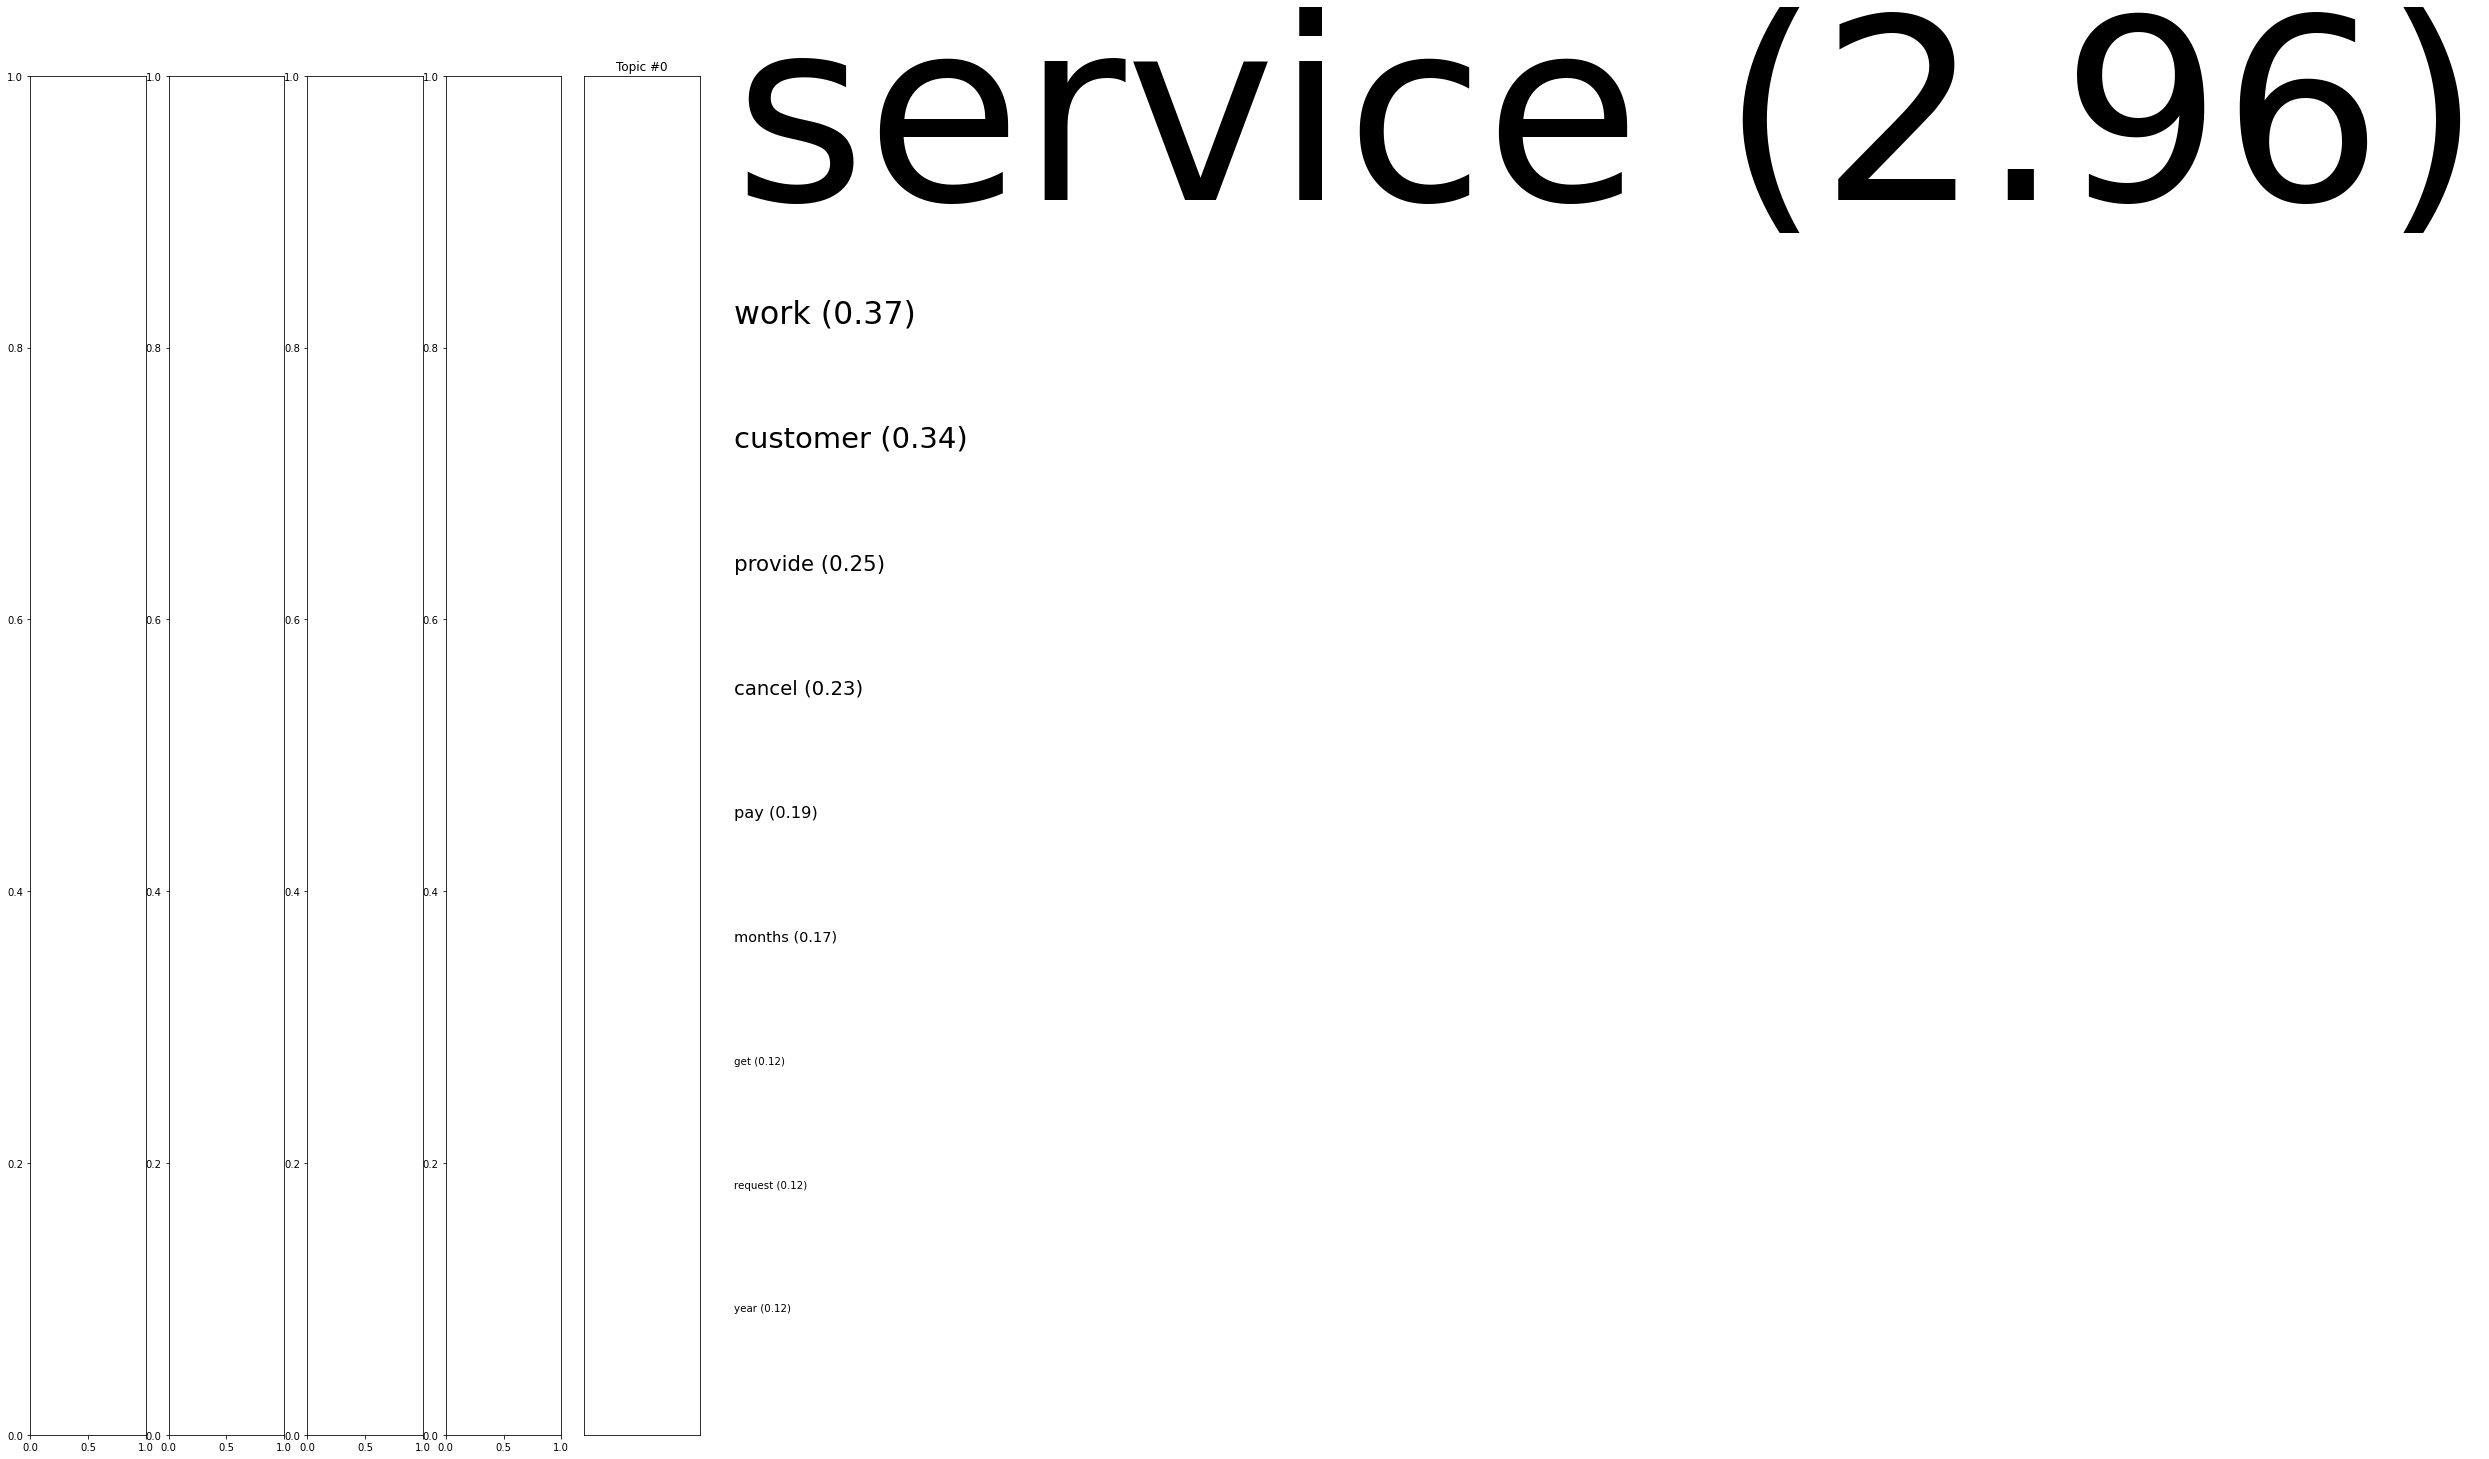

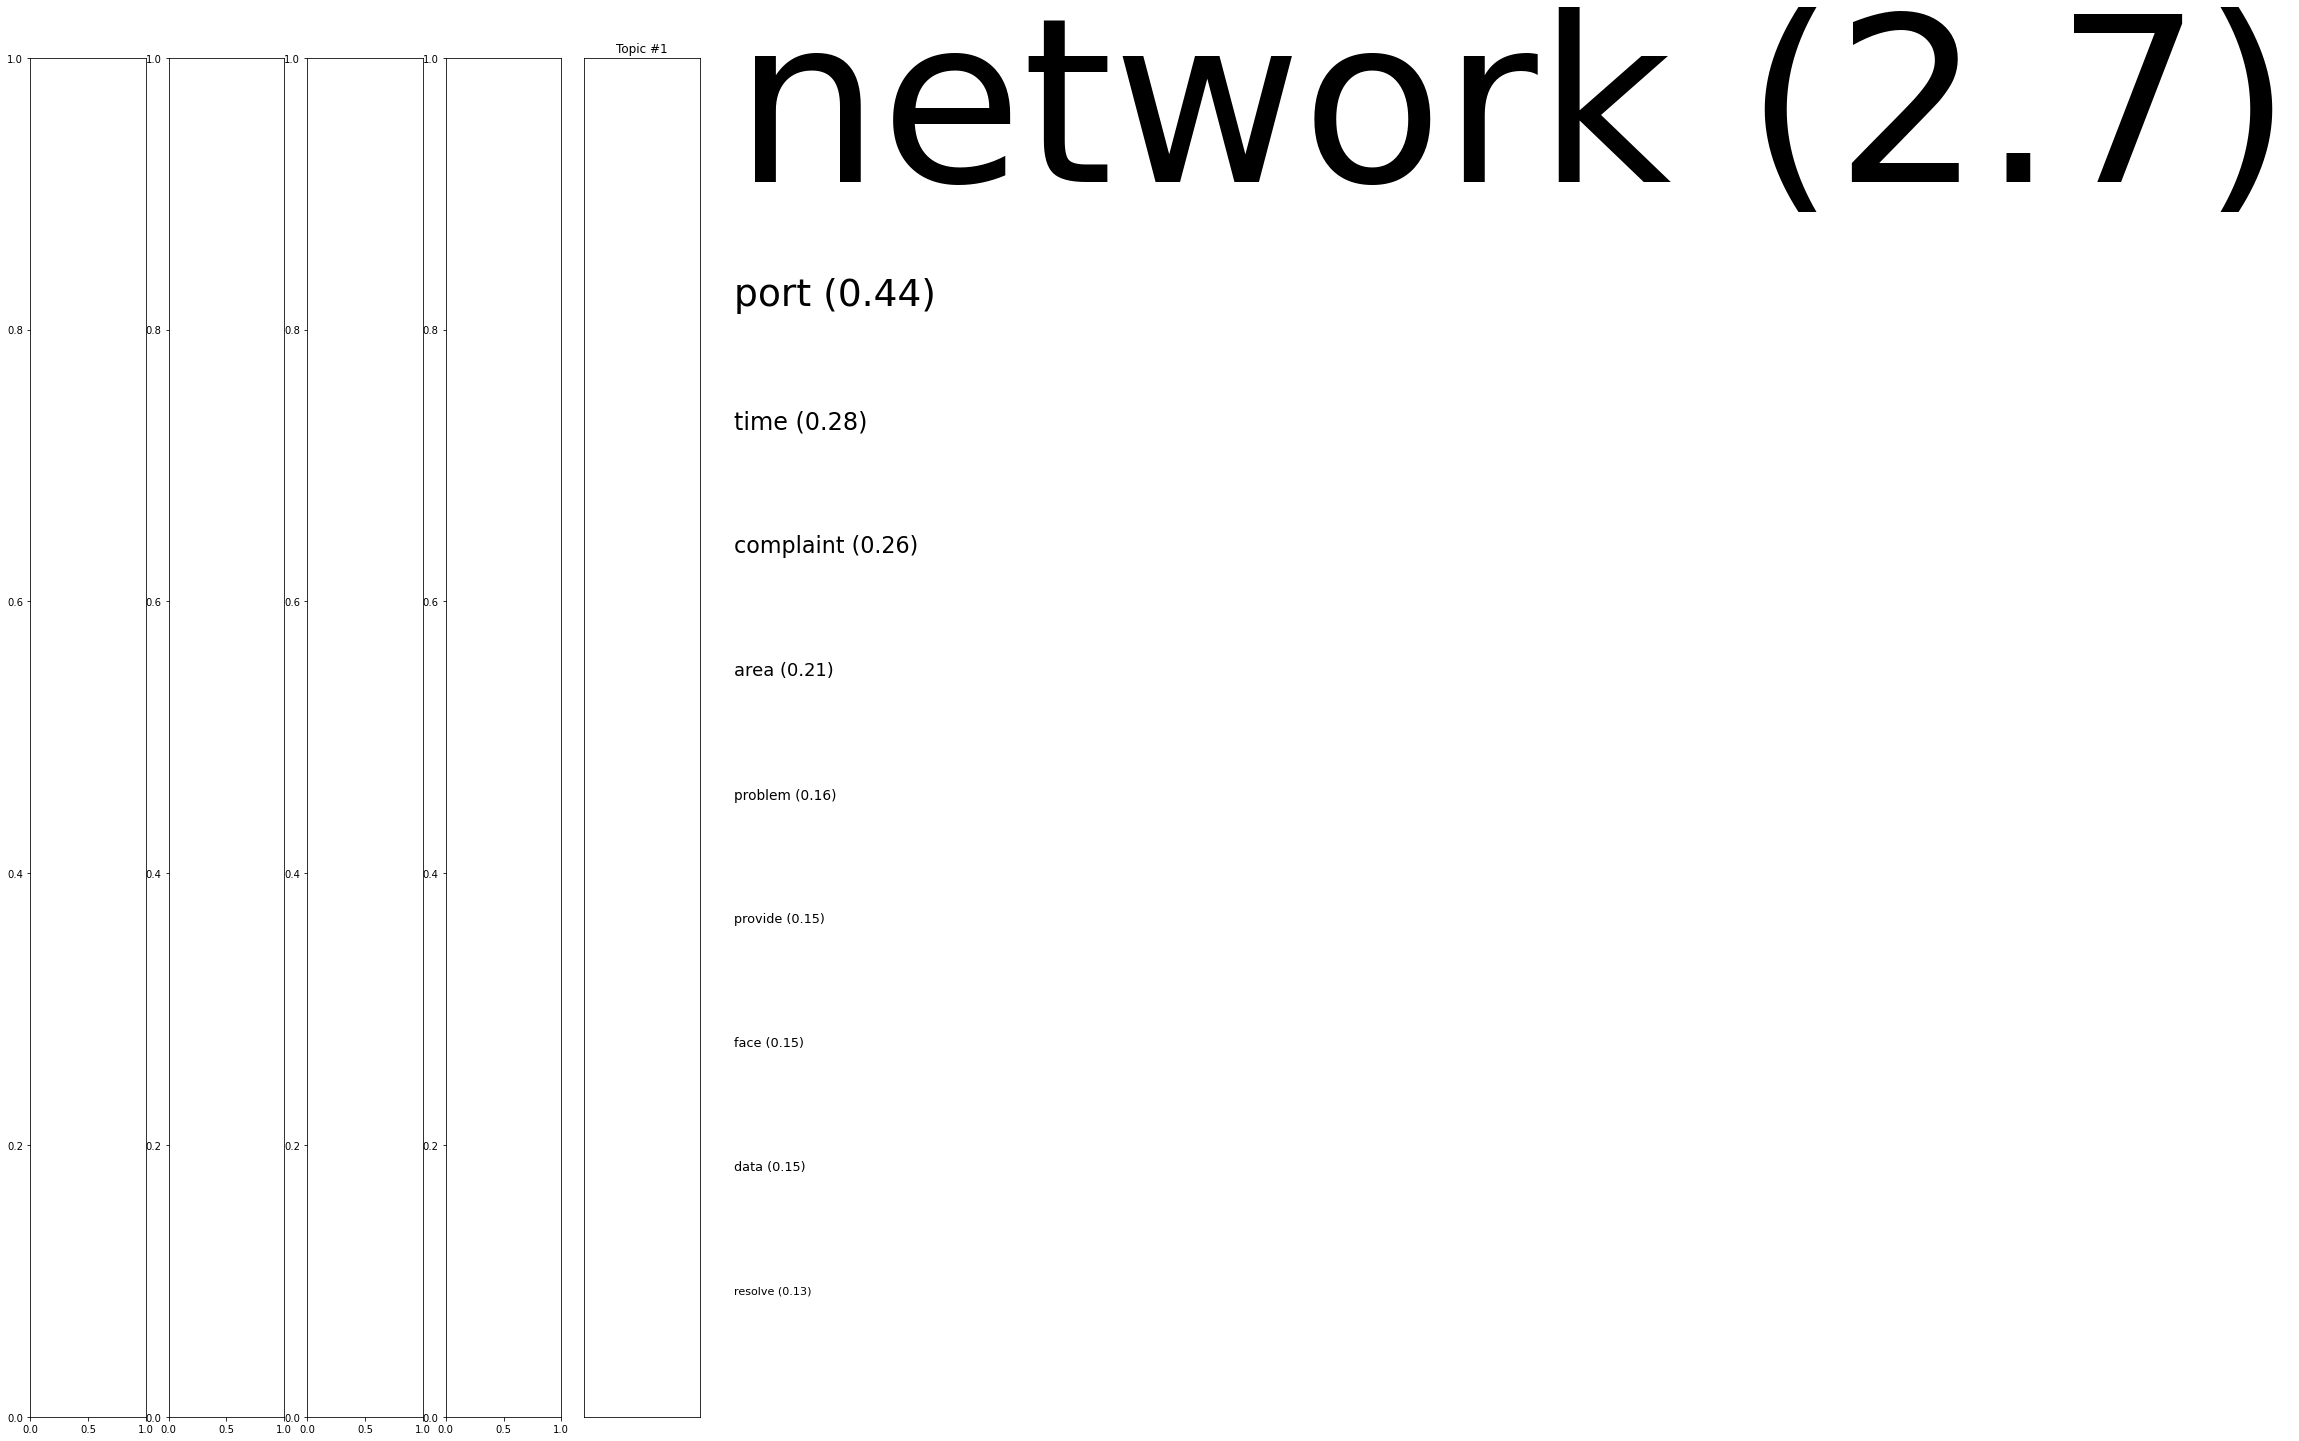

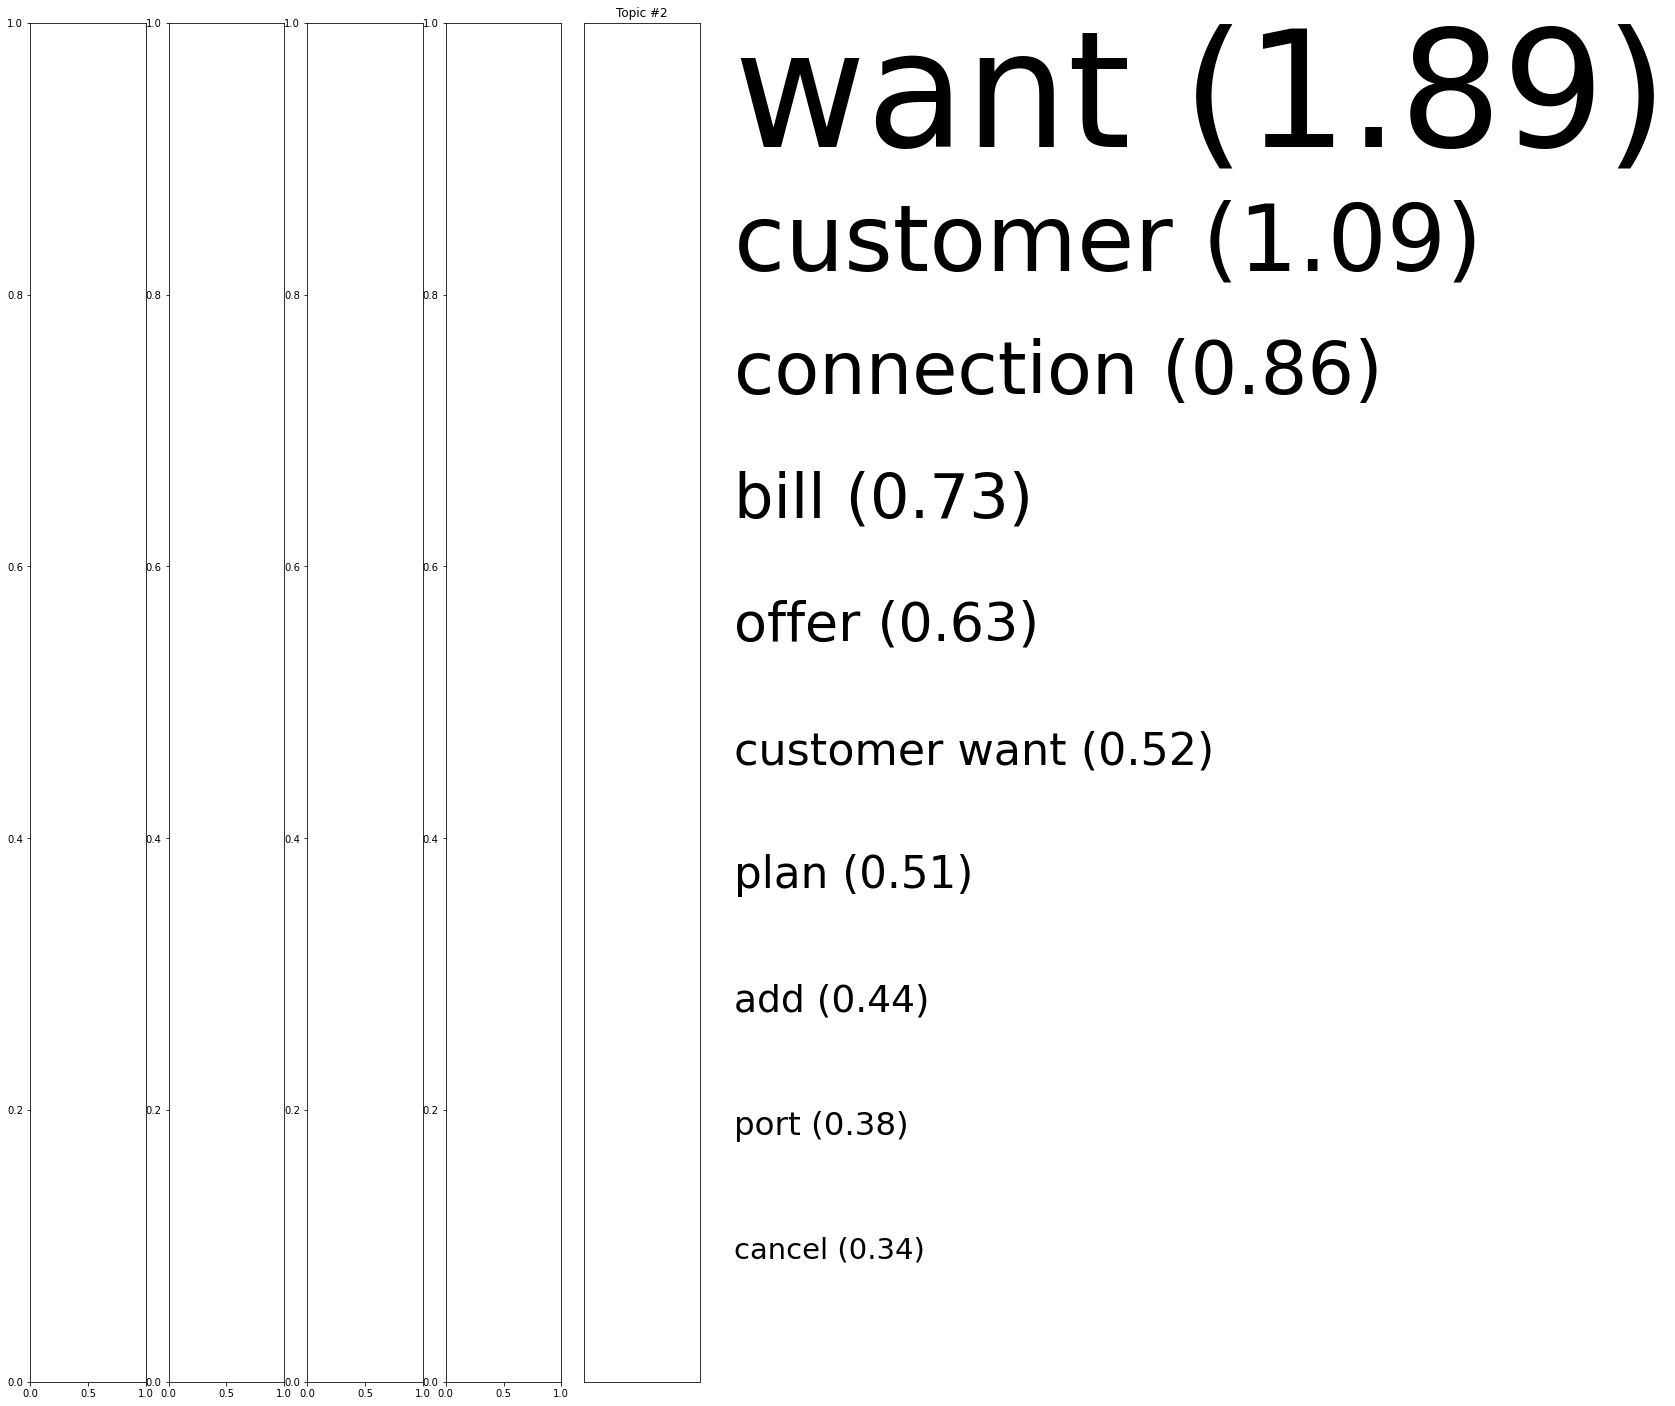

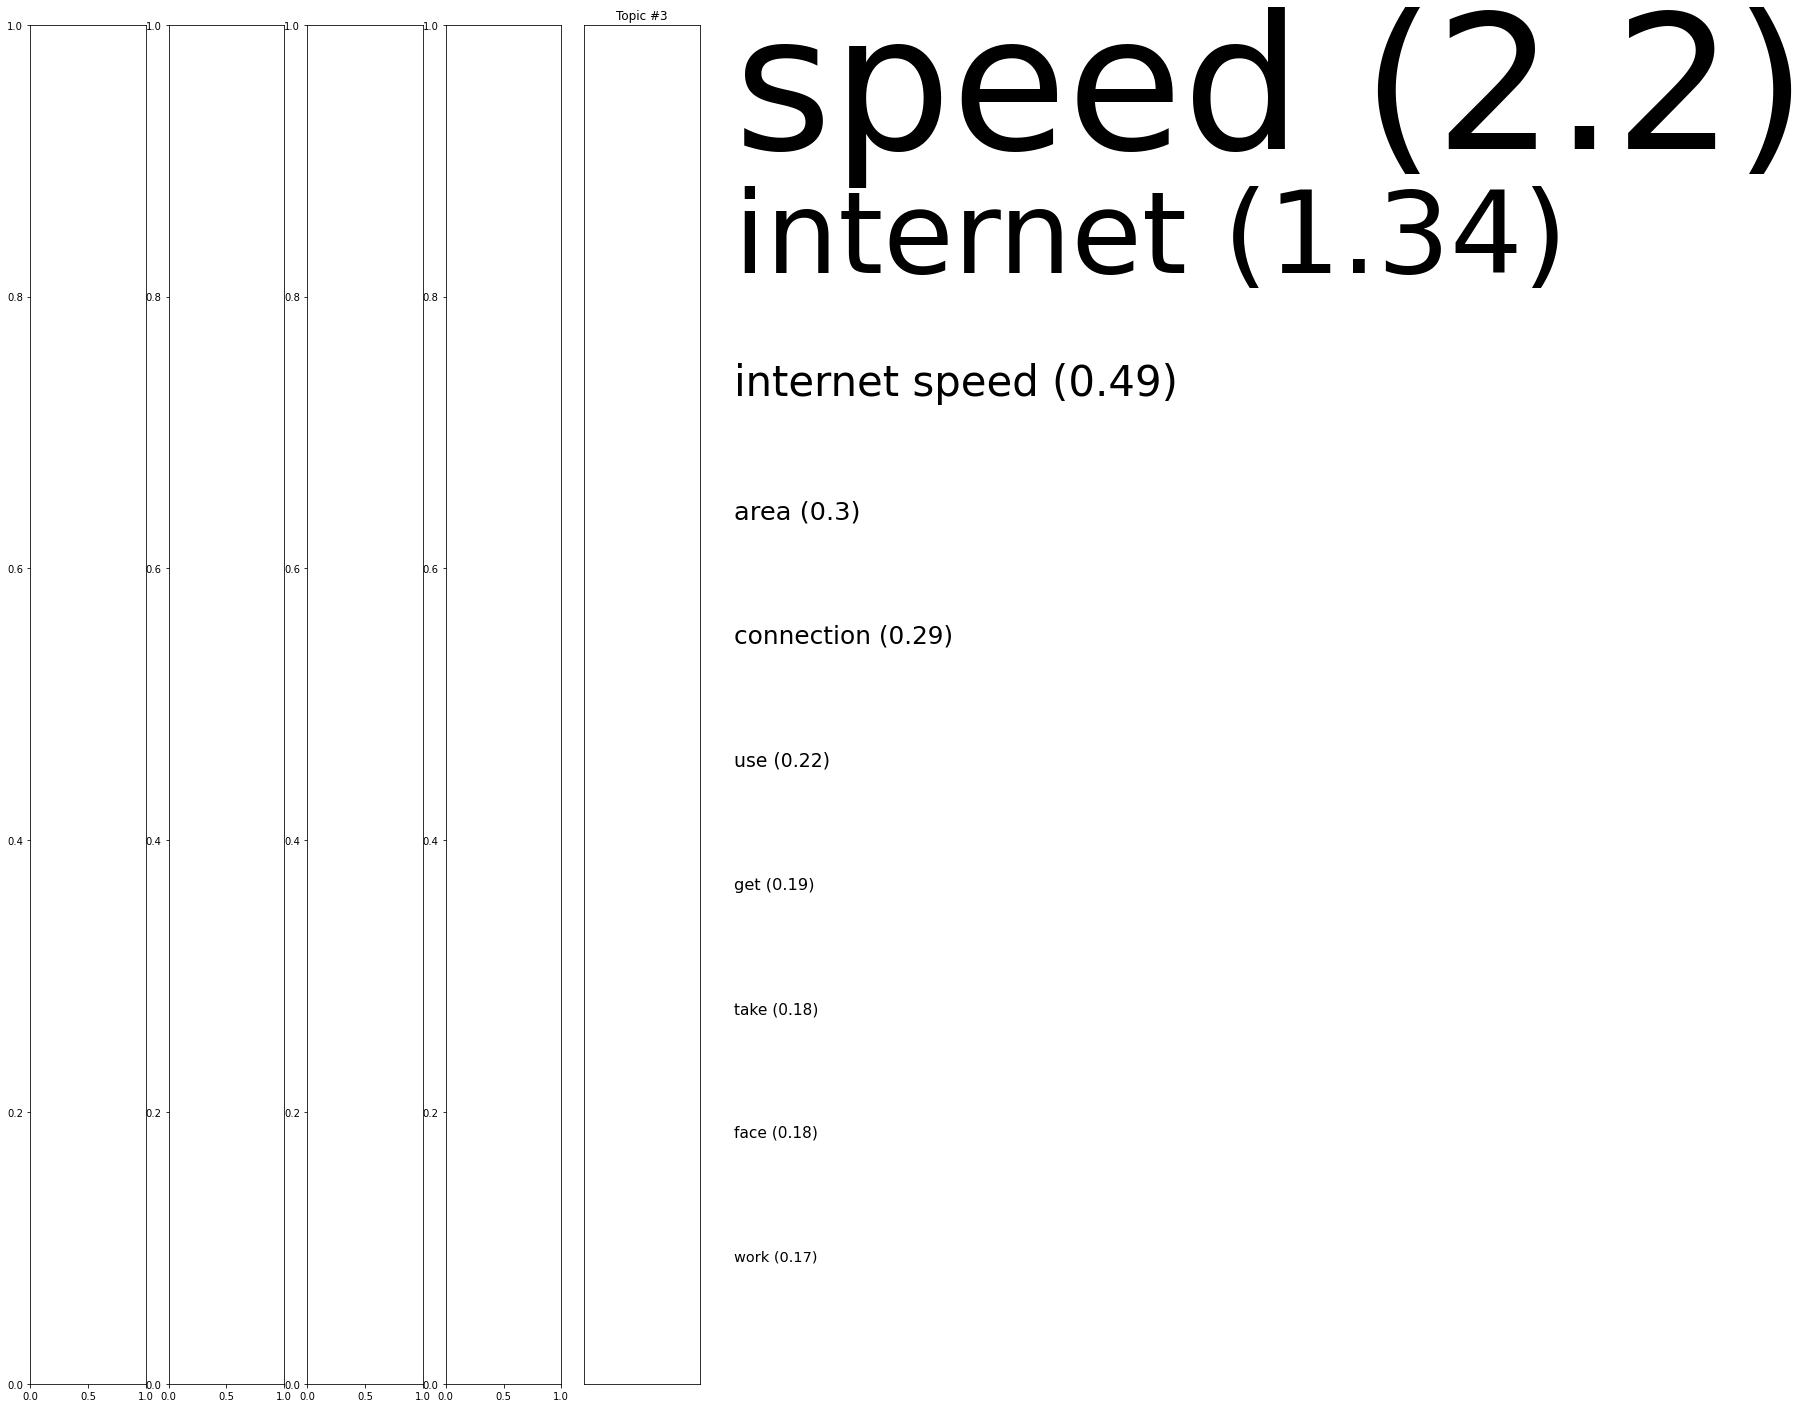

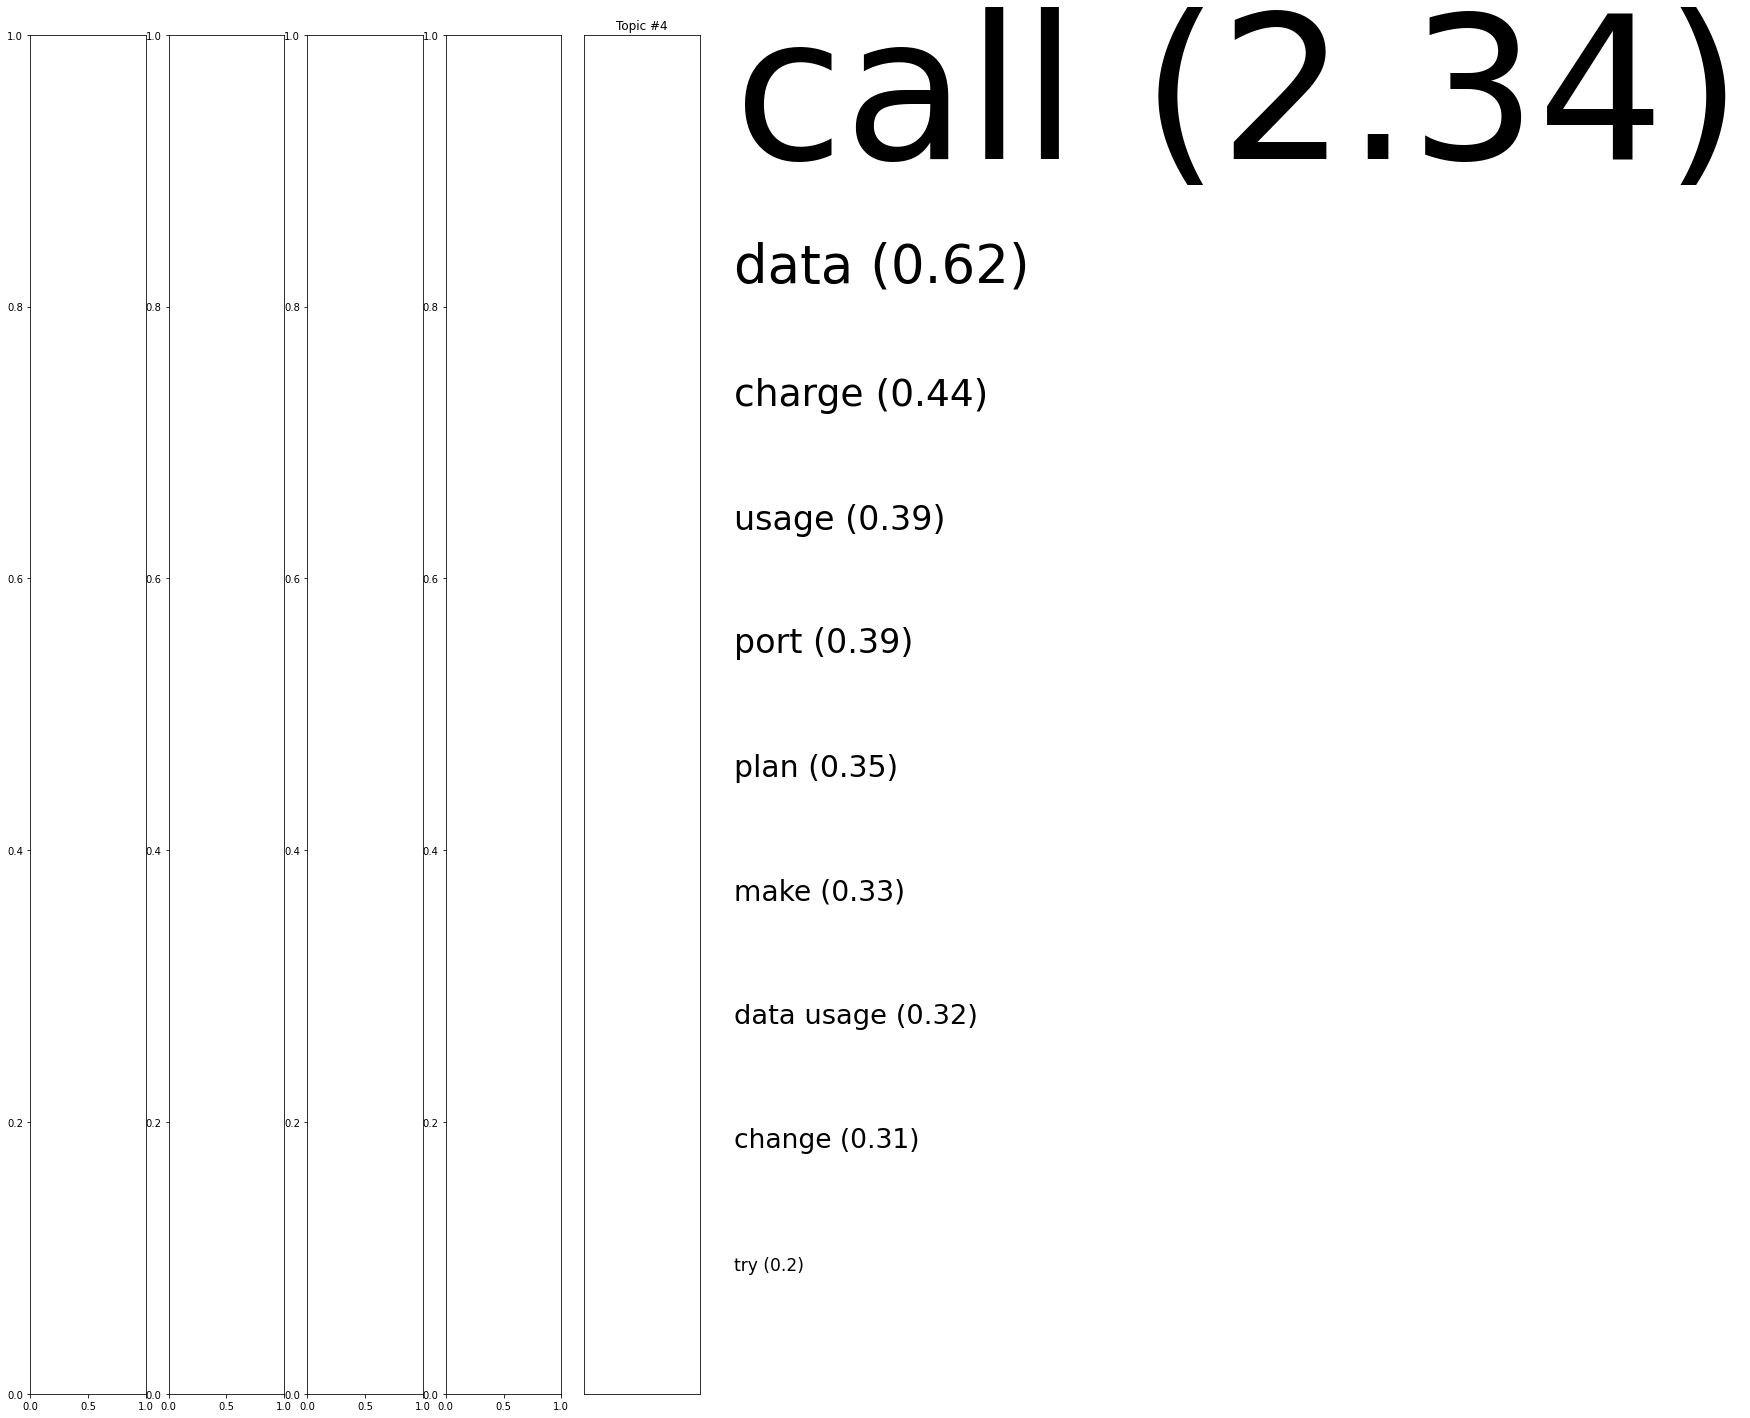

In [35]:
fontsize_base = 20 / np.max(sizes) # font size for word with largest share in corpus
num_top_words = 10

for i in range(total_topics):
    terms, sizes = getTermsAndSizes(topics_display_list[i])
    fig, ax = plt.subplots(1, total_topics, figsize=(12, 25))
    plt.ylim(0, num_top_words + 1.0)
    plt.xticks([])
    plt.yticks([])
    plt.title('Topic #{}'.format(i))

    for j, (word, share) in enumerate(zip(terms, sizes)):
        word = word + " (" + str(share) + ")"
        plt.text(1.3, num_top_words-j, word, fontsize=fontsize_base*share*10)
        #plt.text(1.0, num_top_words-j-0.5, word, fontsize=fontsize_base)

plt.tight_layout()

In [11]:
# This is for GridSearch() to find best number of topics
# Define Search Param
search_params = {'n_components': [2, 3, 4, 5, 10, 15, 20, 25], 'learning_decay': [.5, .7, .9]}  
#n_components - no of features to be used, learning_decay - between 0.5 & 1. Corresponds to kappa - what value of previous lambda is forgotton

# Init the model
lda = LatentDirichletAllocation()

# Init Grid Search class
model2 = GridSearchCV(lda, search_params)   #loops through predefined hyperparams to fit model on training set.

model2.fit(tf)
best_lda_model = model2.best_estimator_
print("Best model's params: ", model2.best_params_)
print("Best log likelihood score: ", model2.best_score_)
print("Model perplexity: ", best_lda_model.perplexity(tf))
df_cv_results = pd.DataFrame(model2.cv_results_)
df_cv_results.to_csv("G:\Symbi\Outcome\LDAGridSearchResults.csv", header=True, index=False, encoding='utf-8')

# Plotting the test score
sns.pointplot(x="param_n_components", y="mean_test_score", hue="param_learning_decay", data=df_cv_results)

# Take the best model
best_lda_model

C:\Users\Tanisha Batra\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Best model's params:  {'learning_decay': 0.7, 'n_components': 2}
Best log likelihood score:  -10337.365231936641
Model perplexity:  2389.8644450889487


In [15]:
model3=LatentDirichletAllocation(batch_size=10, doc_topic_prior=0.1,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=50, max_iter=50, mean_change_tol=0.001,
             n_components=5, n_jobs=None, perp_tol=0.1,
             random_state=None, topic_word_prior=0.01,
             total_samples=500.0, verbose=0)

model3.fit(tf)
#Learn model for the data X with variational Bayes method.
# print log-likelihood

log_likelihood3 =model3.score(tf)
perplexity3= model3.perplexity(tf)
print("  ")
print("Log likelihood: ", log_likelihood3)
print("Perplexity: ", perplexity3)

# Learning_method = {"batch","online"} - Batch Variational Bayes method is used in small dataset. For big dataset, online method is good
# batch_size - Variational Bayes size 
# n_components = no of topics
# doc_topic_prior =float, default=None. Default value = 1 / n_components. Alpha. Prior of document topic distribution theta. 
# topic_word_prior = float. Beta. Prior of topic-word distribtion. 

lda_output = model3.transform(tf)
#print(lda_output)

#lda_output.save('G:/Symbi/Outcome/model3.model')

C:\Users\Tanisha Batra\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  
Log likelihood:  -45693.00105633111
Perplexity:  9089.738941487843


In [16]:
lda_weights = model3.components_
topics = get_topics_terms_weights(lda_weights, tf_feature_names)
print_topics_udf(topics, total_topics=5, num_terms=30, display_weights=True)

Topic #1 with weights
[('service', 27.01), ('network', 20.74), ('internet', 14.99), ('speed', 13.82), ('connection', 13.72), ('call', 13.4), ('customer', 12.63), ('resolve', 11.01), ('work', 10.01), ('try', 9.01), ('team', 8.01), ('help', 7.01), ('care', 7.01), ('connect', 7.01), ('ask', 7.01), ('want', 6.72), ('port', 6.45), ('provide', 6.01), ('area', 6.01), ('get', 6.01), ('support', 6.01), ('request', 5.01), ('problem', 5.01), ('say', 5.01), ('face', 5.01), ('internet speed', 5.01), ('months', 5.01), ('customer care', 5.01), ('issue', 5.01), ('make', 5.01)]
Topic #2 with weights
[('call', 31.62), ('speed', 22.01), ('customer', 19.51), ('connection', 18.85), ('service', 13.11), ('want', 12.9), ('internet', 11.03), ('plan', 10.77), ('data', 9.72), ('usage', 9.01), ('get', 7.21), ('roam', 7.01), ('data usage', 7.01), ('care', 7.01), ('port', 7.01), ('charge', 6.78), ('face', 6.01), ('work', 6.01), ('customer care', 6.01), ('bill', 6.01), ('detail', 5.91), ('offer', 5.01), ('problem', 

C:\Users\Tanisha Batra\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
tweet_txt = raw_df['clean_tweet']

C:\Users\Tanisha Batra\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
# column names
topicnames = ['Topic_' + str(i) for i in range(model3.n_components)]

# index names
docnames = ['Doc_' + str(i) for i in range(len(tweet_txt))]

# create a dataframe
df_document_topic = pd.DataFrame(np.round(lda_output,2), columns=topicnames, index=docnames)

df_document_topic.head(10)

C:\Users\Tanisha Batra\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4
Doc_0,0.03,0.03,0.03,0.03,0.89
Doc_1,0.02,0.02,0.93,0.02,0.02
Doc_2,0.01,0.97,0.01,0.01,0.01
Doc_3,0.00,0.99,0.00,0.00,0.00
Doc_4,0.07,0.07,0.07,0.07,0.73
Doc_5,0.07,0.07,0.07,0.07,0.73
Doc_6,0.03,0.03,0.03,0.03,0.89
Doc_7,0.01,0.01,0.01,0.01,0.98
Doc_8,0.01,0.01,0.01,0.96,0.01
Doc_9,0.99,0.00,0.00,0.00,0.00


In [19]:
df_document_topic['dominant_topic'] = np.argmax(df_document_topic.values, axis=1)
df_document_topic.head(10)

C:\Users\Tanisha Batra\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,dominant_topic
Doc_0,0.03,0.03,0.03,0.03,0.89,4
Doc_1,0.02,0.02,0.93,0.02,0.02,2
Doc_2,0.01,0.97,0.01,0.01,0.01,1
Doc_3,0.00,0.99,0.00,0.00,0.00,1
Doc_4,0.07,0.07,0.07,0.07,0.73,4
Doc_5,0.07,0.07,0.07,0.07,0.73,4
Doc_6,0.03,0.03,0.03,0.03,0.89,4
Doc_7,0.01,0.01,0.01,0.01,0.98,4
Doc_8,0.01,0.01,0.01,0.96,0.01,3
Doc_9,0.99,0.00,0.00,0.00,0.00,0


C:\Users\Tanisha Batra\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\Tanisha Batra\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='dominant_topic', ylabel='count'>

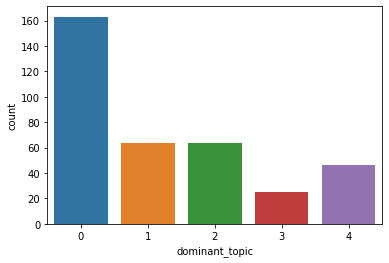

In [21]:
sns.countplot(df_document_topic.dominant_topic)


In [22]:
# components_ contains the word to topic matrix
model3.components_.shape
# check the shape
tf.shape

C:\Users\Tanisha Batra\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(362, 8)

In [23]:
# Topic - Keyword matrix. Each topic keywords

df_topic_keywords = pd.DataFrame(model3.components_)

# assign column and index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# check the head
df_topic_keywords.iloc[:,:10]

C:\Users\Tanisha Batra\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,call,connection,customer,internet,network,service,speed,want
Topic_0,66.01,50.01,11.764285,0.01,0.01,0.01,0.010000,0.01
Topic_1,0.01,0.01,16.260606,0.01,0.01,91.01,0.010000,0.01
Topic_2,0.01,0.01,0.010000,0.01,86.01,0.01,39.453256,0.01
Topic_3,0.01,0.01,0.010000,50.01,0.01,0.01,15.566744,0.01
Topic_4,0.01,0.01,36.005109,0.01,0.01,0.01,0.010000,50.01


In [24]:
# Show top n keywords for each topic
#vectorizer=vectorizer, 
#lda_model=model3, 
n_words=20
keywords = np.array(vectorizer.get_feature_names())

topic_keywords = []
for topic_weights in model3.components_:
    top_keyword_locs = (-topic_weights).argsort()[:n_words]
    topic_keywords.append(keywords.take(top_keyword_locs))
    
topic_keywords

C:\Users\Tanisha Batra\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[array(['call', 'connection', 'customer', 'internet', 'network', 'service',
        'speed', 'want'], dtype='<U10'),
 array(['service', 'customer', 'call', 'connection', 'internet', 'network',
        'speed', 'want'], dtype='<U10'),
 array(['network', 'speed', 'call', 'connection', 'customer', 'internet',
        'service', 'want'], dtype='<U10'),
 array(['internet', 'speed', 'call', 'connection', 'customer', 'network',
        'service', 'want'], dtype='<U10'),
 array(['want', 'customer', 'call', 'connection', 'internet', 'network',
        'service', 'speed'], dtype='<U10')]

In [25]:
# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

C:\Users\Tanisha Batra\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7
Topic 0,call,connection,customer,internet,network,service,speed,want
Topic 1,service,customer,call,connection,internet,network,speed,want
Topic 2,network,speed,call,connection,customer,internet,service,want
Topic 3,internet,speed,call,connection,customer,network,service,want
Topic 4,want,customer,call,connection,internet,network,service,speed


In [26]:
test_vectorizer = CountVectorizer(ngram_range=(1,2), token_pattern='\w+|\$[\d\.]+|\S+') 

C:\Users\Tanisha Batra\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:1: DeprecationWarning: invalid escape sequence \w
<>:1: DeprecationWarning: invalid escape sequence \w
<ipython-input-26-4e27dd1032b7>:1: DeprecationWarning: invalid escape sequence \w
  test_vectorizer = CountVectorizer(ngram_range=(1,2), token_pattern='\w+|\$[\d\.]+|\S+')


In [27]:
# normalize the corpus
#t1 ='@jiocare, I paid on time, why is there fine. Cancel the fine and send a new bill '
#t2 ='@airtel I have complained so many times, but network quality is not improved. Rampant call drop'

test_corpus='@jiocare, I paid on time, why is there fine. Cancel the fine and send a new bill'
#@airtel I have complained so many times, but network quality is not improved. Rampant call drop'

print(test_corpus)

#raw_df= raw_df[pd.notnull(raw_df['Tweet'])] #Delete rows where Tweet is null.

# using list.extend() to concat
#t3=t1.extend(t2)
#print(t3)
#print ("Concatenated list using list.extend() : " + str(t3))

clean_test =[]
clean_test = clean_tweet(test_corpus)
#clean_test = test_corpus.apply(clean_tweet)
clean_test =[clean_test]

print(clean_test)
test_feature_matrix = vectorizer.fit_transform(clean_test)

print(test_feature_matrix.shape)
test_lda_output = model3.transform(test_feature_matrix)
# column names
test_topicnames = ['Topic_' + str(i) for i in range(model3.n_components)]

# index names
test_docnames = ['Doc_' + str(i) for i in range(len(clean_test))]

# create a dataframe
test_df_document_topic = pd.DataFrame(np.round(test_lda_output,2), columns=test_topicnames, index=test_docnames)

# dominant topic
test_df_document_topic['dominant_topic'] = np.argmax(test_df_document_topic.values, axis=1)
test_df_document_topic.head()

#print(clean_test_corpus)

C:\Users\Tanisha Batra\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


@jiocare, I paid on time, why is there fine. Cancel the fine and send a new bill
['pay cancel fine send bill']


ValueError: After pruning, no terms remain. Try a lower min_df or a higher max_df.

In [ ]:
import pyLDAvis.sklearn

dtm = np.matrix(tf)
print(dtm)
#pyLDAvis.sklearn.prepare(lda_model, dtm, vectorizer)
panel = pyLDAvis.sklearn.prepare(model3, dtm, vectorizer,mds='tsne')
pyLDAvis.display(panel)

In [ ]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=5, random_state=43,  alpha=0.01, l1_ratio=0.5)
nmf_output = nmf.fit_transform(tfidf_feature_matrix)

nmf_feature_names = tfidf_vectorizer.get_feature_names()
nmf_weights = nmf.components_

In [ ]:
from bokeh.io import show, output_notebook, push_notebook, output_file
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.models import CategoricalColorMapper
from bokeh.layouts import row
from bokeh.layouts import gridplot
output_notebook()

# Make a source and a scatter plot  
source = ColumnDataSource(df_document_topic)

# define plot 1
plot1 = figure(x_axis_label = 'PC 1',
              y_axis_label = 'PC 2', title="Clustering Results",
              width = 500, height = 400)

# add color
palette = ['#FF7373', '#61F2F5']
color_map1 = CategoricalColorMapper(factors=df_document_topic['cluster'].unique(), palette=palette)

plot1.circle(x = 'pc1',
    y = 'pc2',
    source = source,
             color = {'field': 'cluster', 'transform': color_map1},
             legend='cluster', alpha = .8)


# Create a HoverTool object
hover1 = HoverTool(tooltips = [('Issue', '@movie'),
                               ('Dominant_topic', '@dominant_topic'),
                               ('Cluster', '@cluster'),
                               ('Predicted_sentiment', '@predicted_sentiment'),
                               ('Actual_Sentiment', '@sentiment'),
                               ('Sentiment_score', '@sentiment_score')
                              ])
plot1.add_tools(hover1)



### plot2
plot2 = figure(x_axis_label = 'PC 1',
              y_axis_label = 'PC 2', title="Predicted Sentiment",
              width = 500, height = 400)

color_map2 = CategoricalColorMapper(factors=df_document_topic['predicted_sentiment'].unique(), palette=palette)

plot2.circle(x = 'pc1',
    y = 'pc2',
    source = source, color = {'field': 'predicted_sentiment', 'transform': color_map2},
            legend='predicted_sentiment', alpha = .8)



# Create a HoverTool object
hover2 = HoverTool(tooltips = [('Movie', '@movie'),
                               ('Dominant_topic', '@dominant_topic'),
                               ('Cluster', '@cluster'),
                               ('Predicted_sentiment', '@predicted_sentiment'),
                               ('Actual_Sentiment', '@sentiment'),
                               ('Sentiment_score', '@sentiment_score')
                              ])

plot2.add_tools(hover2)



### plot3
plot3 = figure(x_axis_label = 'PC 1',
              y_axis_label = 'PC 2', title="Dominant Topic",
              width = 500, height = 400)

color_map3 = CategoricalColorMapper(factors=df_document_topic['dominant_topic'].unique(), palette=palette)

plot3.circle(x = 'pc1',
    y = 'pc2',
    source = source, color = {'field': 'dominant_topic', 'transform': color_map3},
            legend='dominant_topic', alpha = .8)



# Create a HoverTool object
hover3 = HoverTool(tooltips = [('Movie', '@movie'),
                               ('Dominant_topic', '@dominant_topic'),
                               ('Cluster', '@cluster'),
                               ('Predicted_sentiment', '@predicted_sentiment'),
                               ('Actual_Sentiment', '@sentiment'),
                               ('Sentiment_score', '@sentiment_score')
                              ])

plot3.add_tools(hover3)



### plot4
plot4 = figure(x_axis_label = 'PC 1',
              y_axis_label = 'PC 2', title="Actual Sentiment",
              width = 500, height = 400)

color_map4 = CategoricalColorMapper(factors=df_document_topic['sentiment'].unique(), palette=palette)

plot4.circle(x = 'pc1',
    y = 'pc2',
    source = source, color = {'field': 'sentiment', 'transform': color_map4},
            legend='sentiment', alpha = .8)



# Create a HoverTool object
hover4 = HoverTool(tooltips = [('Movie', '@movie'),
                               ('Dominant_topic', '@dominant_topic'),
                               ('Cluster', '@cluster'),
                               ('Predicted_sentiment', '@predicted_sentiment'),
                               ('Actual_Sentiment', '@sentiment'),
                               ('Sentiment_score', '@sentiment_score')
                              ])

plot4.add_tools(hover4)

# link the ranges
plot2.x_range = plot1.x_range
plot2.y_range = plot1.y_range
plot3.x_range = plot1.x_range
plot3.y_range = plot1.y_range
plot4.x_range = plot1.x_range
plot4.y_range = plot1.y_range

#layout
row2 = [plot4, plot2]
row1 = [plot1, plot3]
layout = gridplot([row1, row2])